# Approximate single value decomposition

The aproximate implementation works by:
* binned the movie in 1 s bins (per channel)
* Estimating U from the binned movie.
* Iterating over the raw data to estimate S.VT 

Details in wfield-tools/decomposition.py 

To use baseline of each trial you can use the frames_average_trials intead of frames_average. For that data needs to be loaded per trial which is slower. To speed up use a global baseline if possible (i.e. pass `frames_average` with 3 dimensions (ch,w,h) or set `onsets` to None).

Subtracting the baseline per trial may help dealing with slow drifts in fluorescence.

In [1]:
from wfieldtools import *

localdisk = 'd:\\temp_folder'
dat_path = glob(pjoin(localdisk,'*.dat'))[0]
frames_average = np.load(pjoin(localdisk,'frames_average.npy'))

dat = mmap_dat(dat_path)

U,SVT = approximate_svd(dat, frames_average)
np.save(pjoin(localdisk,'Ua.npy'),U)
np.save(pjoin(localdisk,'SVTa.npy'),SVT)

Computing SVT from the raw data: 100%|██████████| 79/79 [04:12<00:00,  3.19s/it]


In [13]:
# Reconstruct and reshape into 2 channels
onset = 100
nframes = 1000
mov = reconstruct(U,SVT[:,onset:onset+nframes*2],
                  dims = dat.shape[-2:]).reshape(nframes,2,*dat.shape[-2:])

# take a look at the differerce between the raw and the reconstructed
napari_show((mov*frames_average)+frames_average - dat[onset:onset+nframes])

In [15]:
# Explore the reconstructed dataset
napari_show(mov)

<Figure size 432x288 with 0 Axes>

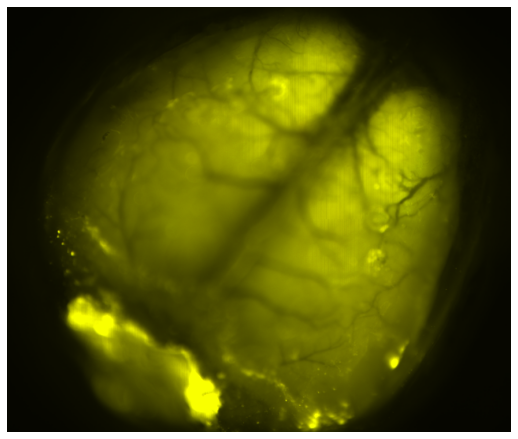

<Figure size 432x288 with 0 Axes>

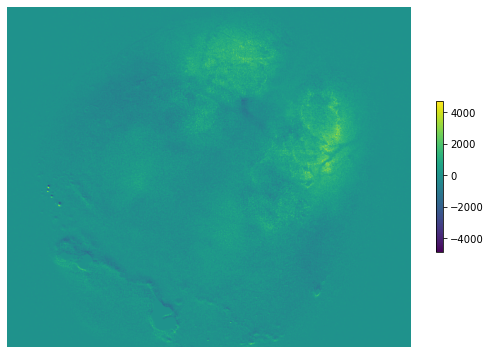

In [16]:
# Compare single frames
%matplotlib inline
# green is raw; red is reconstructed
check = np.stack([((mov[0]*frames_average)+frames_average)[0],dat[onset,0]])
plt.figure();
imshow_noborder(two_chan_to_rgb(check));
plt.figure();
imshow_noborder(np.diff(check,axis=0).squeeze());
plt.colorbar(shrink = 0.3);

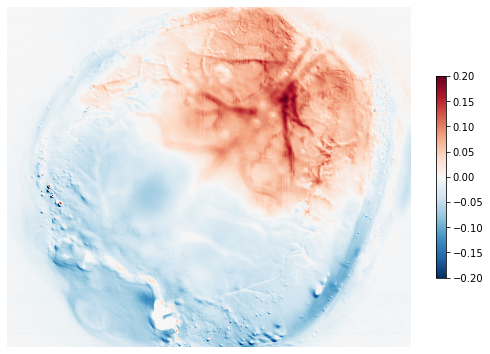

In [31]:
imshow_noborder(reconstruct(U,SVT[:,-60],dims = dat.shape[-2:]).squeeze(),
                cmap = 'RdBu_r',clim=[-.2,.2]);
plt.colorbar(shrink = .4);

### Here's how to run the SVD but removing the baseline at each trial independently

The residuals are better like this but use with care.

In [ ]:
from wfieldtools import *

localdisk = 'd:\\temp_folder'
dat_path = glob(pjoin(localdisk,'*.dat'))[0]
trial_onsets = np.load(pjoin(localdisk,'trial_onsets.npy'))

dat = mmap_dat(dat_path) # load to memory if you have enough
onsets = trial_onsets['iframe']

nbaseline_frames = 30
frames_average_trials = frames_average_for_trials(dat,
                                                  onsets,
                                                  nbaseline_frames)

U,SVT = approximate_svd(dat, frames_average_trials,onsets = onsets)
np.save(pjoin(localdisk,'Ua.npy'),U)
np.save(pjoin(localdisk,'SVTa.npy'),SVT)

In [ ]:
# this is to load the data for a specific trial

onsets = np.load(pjoin(localdisk,'trial_onsets.npy'))['iframe']
# Look at the difference between the reconstructed and the raw data
itrial = 400 # select a trial, but this can be done for any frame
ii = (onsets[itrial],onsets[itrial+1])
nframes = ii[1]-ii[0]
# Reconstruct and reshape into 2 channels
mov = reconstruct(U,SVT[:,ii[0]*2:ii[0]*2+nframes*2],
                  dims = dat.shape[-2:]).reshape(nframes,2,*dat.shape[-2:])
# This is the same as just using the frames_average unless frames_average is ntrials X nchannels X Wpix X Hpix
avg =  get_trial_baseline(ii[0],frames_average,onsets)

# take a look at the differerce between the raw and the reconstructed
napari_show((mov*avg)+avg - dat[ii[0]:ii[1]])